# Multichannel Architecture Experiment Results

In [1]:
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.stats.api as sms

from db import conn

/u3/z3tu/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%matplotlib inline

In [3]:
sns.set_style("whitegrid")

In [5]:
cursor = conn.cursor()
experiment_rows = [r for r in cursor.execute("""
    select g.name, args, dev_metric, test_metric from experiments e
    join experiment_groups g on e.group_id=g.gid
    where g.name=?""", ('conv2d',))]

In [7]:
experiment_rows

[('conv2d',
  '{"program": "python", "main": "/u/z3tu/castorini/MP-CNN-Variants/main.py", "arg2": "/u/z3tu/castorini/MP-CNN-Variants/saved_models/arch_mpcnn_dataset_sick_seed_332119.castor", "arch": "mpcnn", "dataset": "sick", "epochs": 19, "device": 2, "lr": 0.00016, "regularization": 0.0002044, "dropout": 0, "eps": 1e-08, "seed": 332119}',
  '{"pearson": 0.861877, "spearman": 0.816262343959, "kl_div": 0.49034155654907224}',
  '{"pearson": 0.863374, "spearman": 0.797333994568, "kl_div": 0.484521126442273}'),
 ('conv2d',
  '{"program": "python", "main": "/u/z3tu/castorini/MP-CNN-Variants/main.py", "arg2": "/u/z3tu/castorini/MP-CNN-Variants/saved_models/arch_mpcnn_dataset_wikiqa_seed_332119.castor", "arch": "mpcnn", "dataset": "wikiqa", "epochs": 10, "device": 2, "lr": 0.00016, "regularization": 0.0002044, "dropout": 0, "eps": 1e-08, "seed": 332119}',
  '{"cross_entropy_loss": 0.501270262962949, "map": 0.7422, "mrr": 0.7501}',
  '{"cross_entropy_loss": 0.5321748811404586, "map": 0.6688,

In [123]:
experiment_results = {
    'trecqa': [],
    'wikiqa': [],
    'sick': []
}

for row in experiment_rows:
    args = json.loads(row[1])
    dev_metrics = json.loads(row[2])
    test_metrics = json.loads(row[3])
    dataset = args['dataset']
    
    if args['arch'] == 'mpcnn_no_per_dim_no_multi_pooling':
        arch = 'MP-CNN Lite'
    elif args['arch'] == 'smcnn_with_comp':
        arch = 'SM-CNN with Comp'
    else:
        arch = 'MP-CNN'
    
    res_base = {
        'arch': arch,
        'dataset': dataset,
        'seed': args['seed']
    }
    
    results = []
    
    if dataset in ('trecqa', 'wikiqa'):
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'MAP', 'metric_val': dev_metrics['map']}})
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'MRR', 'metric_val': dev_metrics['mrr']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'MAP', 'metric_val': test_metrics['map']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'MRR', 'metric_val': test_metrics['mrr']}})
    elif dataset == 'sick':
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'pearson', 'metric_val': dev_metrics['pearson']}})
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'spearman', 'metric_val': dev_metrics['spearman']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'pearson', 'metric_val': test_metrics['pearson']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'spearman', 'metric_val': test_metrics['spearman']}})
    
    experiment_results[dataset].extend(results)

In [124]:
trecqa = pd.DataFrame(experiment_results['trecqa'])
wikiqa = pd.DataFrame(experiment_results['wikiqa'])
sick = pd.DataFrame(experiment_results['sick'])

In [125]:
trecqa['arch'].unique()

array(['MP-CNN Lite', 'MP-CNN', 'SM-CNN with Comp'], dtype=object)

In [204]:
archs = ['MP-CNN', 'MP-CNN Lite', 'SM-CNN with Comp']
def compare_change_to_baseline(df, metric):
    config_ids = df['seed'].unique()
    for arch in archs:
        diffs = []
        for config_id in config_ids:
            baseline = df[(df['seed'] == config_id) & (df['arch'] == 'MP-CNN')].iloc[0]['metric_val']
            conf_perf = df[(df['seed'] == config_id) & (df['arch'] == arch)].iloc[0]['metric_val']
            diffs.append(conf_perf - baseline)

        print(f'Architecture: {arch}')
        print(f'Median of {metric} change compared with single baseline: {np.median(diffs):.4f}')
        print(f'Mean of {metric} change compared with single baseline: {np.mean(diffs):.4f}')

## TrecQA

In [205]:
trec_map_vs_archs_test = trecqa[(trecqa['metric_name'] == 'MAP') & (trecqa['split'] == 'test')]
trec_mrr_vs_archs_test = trecqa[(trecqa['metric_name'] == 'MRR') & (trecqa['split'] == 'test')]
trec_map_vs_archs_dev = trecqa[(trecqa['metric_name'] == 'MAP') & (trecqa['split'] == 'dev')]
trec_mrr_vs_archs_dev = trecqa[(trecqa['metric_name'] == 'MRR') & (trecqa['split'] == 'dev')]

In [206]:
for arch in trec_map_vs_archs_test['arch'].unique():
    arr = trec_map_vs_archs_test[trec_map_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

MP-CNN Lite: (0.7581, 0.7749)
MP-CNN: (0.6363, 0.7889)
SM-CNN with Comp: (0.6821, 0.7011)


In [207]:
for arch in trec_mrr_vs_archs_test['arch'].unique():
    arr = trec_mrr_vs_archs_test[trec_mrr_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

MP-CNN Lite: (0.8031, 0.8243)
MP-CNN: (0.6838, 0.8355)
SM-CNN with Comp: (0.7458, 0.7767)


In [208]:
trec_map_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
MP-CNN,0.71258,548872.6
MP-CNN Lite,0.76651,548872.6
SM-CNN with Comp,0.69161,548872.6


In [209]:
trec_mrr_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
MP-CNN,0.75962,548872.6
MP-CNN Lite,0.81370,548872.6
SM-CNN with Comp,0.76125,548872.6


In [210]:
trec_map_vs_archs_test.sort_values('seed')

,arch,dataset,metric_name,metric_val,seed,split
2,MP-CNN Lite,trecqa,MAP,0.7617,143142,test
86,SM-CNN with Comp,trecqa,MAP,0.7161,143142,test
22,MP-CNN,trecqa,MAP,0.7926,143142,test
110,SM-CNN with Comp,trecqa,MAP,0.6764,196571,test
34,MP-CNN Lite,trecqa,MAP,0.7858,196571,test
54,MP-CNN,trecqa,MAP,0.5705,196571,test
102,SM-CNN with Comp,trecqa,MAP,0.6966,211554,test
70,MP-CNN Lite,trecqa,MAP,0.7525,211554,test
66,MP-CNN,trecqa,MAP,0.7765,211554,test
114,SM-CNN with Comp,trecqa,MAP,0.6906,304760,test


In [211]:
compare_change_to_baseline(trec_map_vs_archs_test, 'MAP')

Architecture: MP-CNN
Median of MAP change compared with single baseline: 0.0000
Mean of MAP change compared with single baseline: 0.0000
Architecture: MP-CNN Lite
Median of MAP change compared with single baseline: -0.0031
Mean of MAP change compared with single baseline: 0.0539
Architecture: SM-CNN with Comp
Median of MAP change compared with single baseline: -0.0747
Mean of MAP change compared with single baseline: -0.0210


In [212]:
compare_change_to_baseline(trec_mrr_vs_archs_test, 'MRR')

Architecture: MP-CNN
Median of MRR change compared with single baseline: 0.0000
Mean of MRR change compared with single baseline: 0.0000
Architecture: MP-CNN Lite
Median of MRR change compared with single baseline: -0.0026
Mean of MRR change compared with single baseline: 0.0541
Architecture: SM-CNN with Comp
Median of MRR change compared with single baseline: -0.0460
Mean of MRR change compared with single baseline: 0.0016


## WikiQA

In [213]:
wikiqa_map_vs_archs_test = wikiqa[(wikiqa['metric_name'] == 'MAP') & (wikiqa['split'] == 'test')]
wikiqa_mrr_vs_archs_test = wikiqa[(wikiqa['metric_name'] == 'MRR') & (wikiqa['split'] == 'test')]
wikiqa_map_vs_archs_dev = wikiqa[(wikiqa['metric_name'] == 'MAP') & (wikiqa['split'] == 'dev')]
wikiqa_mrr_vs_archs_dev = wikiqa[(wikiqa['metric_name'] == 'MRR') & (wikiqa['split'] == 'dev')]

In [214]:
for arch in wikiqa_map_vs_archs_test['arch'].unique():
    arr = wikiqa_map_vs_archs_test[wikiqa_map_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

MP-CNN: (0.4592, 0.6862)
MP-CNN Lite: (0.6711, 0.7029)
SM-CNN with Comp: (0.4955, 0.6554)


In [215]:
for arch in wikiqa_mrr_vs_archs_test['arch'].unique():
    arr = wikiqa_mrr_vs_archs_test[wikiqa_mrr_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

MP-CNN: (0.4643, 0.6999)
MP-CNN Lite: (0.6834, 0.7160)
SM-CNN with Comp: (0.5012, 0.6690)


In [216]:
wikiqa_map_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
MP-CNN,0.57271,548872.6
MP-CNN Lite,0.68702,548872.6
SM-CNN with Comp,0.57546,548872.6


In [217]:
wikiqa_mrr_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
MP-CNN,0.58214,548872.6
MP-CNN Lite,0.69969,548872.6
SM-CNN with Comp,0.58510,548872.6


In [218]:
compare_change_to_baseline(wikiqa_map_vs_archs_test, 'MAP')

Architecture: MP-CNN
Median of MAP change compared with single baseline: 0.0000
Mean of MAP change compared with single baseline: 0.0000
Architecture: MP-CNN Lite
Median of MAP change compared with single baseline: 0.0033
Mean of MAP change compared with single baseline: 0.1143
Architecture: SM-CNN with Comp
Median of MAP change compared with single baseline: -0.0425
Mean of MAP change compared with single baseline: 0.0027


In [219]:
compare_change_to_baseline(wikiqa_mrr_vs_archs_test, 'MRR')

Architecture: MP-CNN
Median of MRR change compared with single baseline: 0.0000
Mean of MRR change compared with single baseline: 0.0000
Architecture: MP-CNN Lite
Median of MRR change compared with single baseline: -0.0007
Mean of MRR change compared with single baseline: 0.1176
Architecture: SM-CNN with Comp
Median of MRR change compared with single baseline: -0.0448
Mean of MRR change compared with single baseline: 0.0030


(array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Text yticklabel objects>)

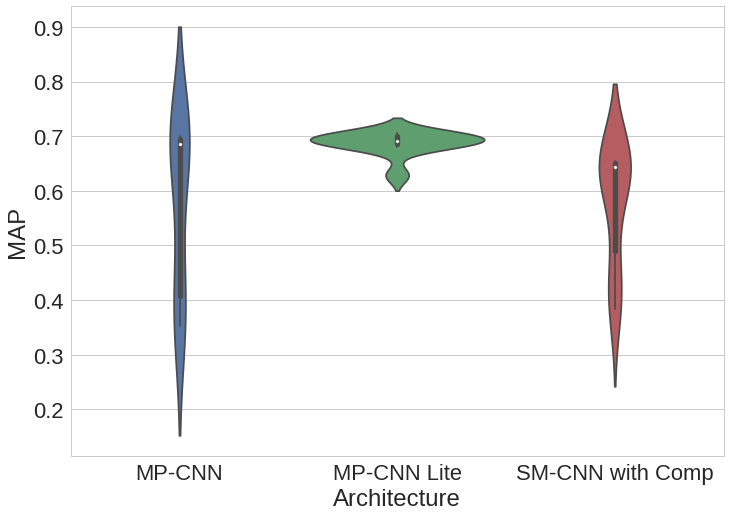

In [220]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.violinplot(x='arch', y='metric_val', data=wikiqa_map_vs_archs_test, order=archs, ax=ax)
plt.xlabel('Architecture', fontsize=24)
plt.ylabel('MAP', fontsize=24)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
# plt.ylim(0.6, 0.75)

## SICK

In [221]:
sick_pearson_vs_archs_test = sick[(sick['metric_name'] == 'pearson') & (sick['split'] == 'test')]
sick_spearman_vs_archs_test = sick[(sick['metric_name'] == 'spearman') & (sick['split'] == 'test')]
sick_pearson_vs_archs_dev = sick[(sick['metric_name'] == 'pearson') & (sick['split'] == 'dev')]
sick_spearman_vs_archs_dev = sick[(sick['metric_name'] == 'spearman') & (sick['split'] == 'dev')]

In [222]:
for arch in sick_pearson_vs_archs_test['arch'].unique():
    arr = sick_pearson_vs_archs_test[sick_pearson_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

MP-CNN: (0.8649, 0.8733)
MP-CNN Lite: (0.8604, 0.8683)
SM-CNN with Comp: (0.7976, 0.8030)


In [223]:
for arch in sick_spearman_vs_archs_test['arch'].unique():
    arr = sick_spearman_vs_archs_test[sick_spearman_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

MP-CNN: (0.7990, 0.8103)
MP-CNN Lite: (0.7958, 0.8053)
SM-CNN with Comp: (0.7393, 0.7450)


In [224]:
sick_pearson_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
MP-CNN,0.869105,548872.6
MP-CNN Lite,0.864389,548872.6
SM-CNN with Comp,0.800321,548872.6


In [225]:
sick_spearman_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
MP-CNN,0.804639,548872.6
MP-CNN Lite,0.800537,548872.6
SM-CNN with Comp,0.742191,548872.6


In [226]:
compare_change_to_baseline(sick_pearson_vs_archs_test, 'pearson')

Architecture: MP-CNN
Median of pearson change compared with single baseline: 0.0000
Mean of pearson change compared with single baseline: 0.0000
Architecture: MP-CNN Lite
Median of pearson change compared with single baseline: -0.0053
Mean of pearson change compared with single baseline: -0.0047
Architecture: SM-CNN with Comp
Median of pearson change compared with single baseline: -0.0670
Mean of pearson change compared with single baseline: -0.0688


In [227]:
compare_change_to_baseline(sick_spearman_vs_archs_test, 'spearman')

Architecture: MP-CNN
Median of spearman change compared with single baseline: 0.0000
Mean of spearman change compared with single baseline: 0.0000
Architecture: MP-CNN Lite
Median of spearman change compared with single baseline: -0.0042
Mean of spearman change compared with single baseline: -0.0041
Architecture: SM-CNN with Comp
Median of spearman change compared with single baseline: -0.0606
Mean of spearman change compared with single baseline: -0.0624


(array([ 0.78,  0.8 ,  0.82,  0.84,  0.86,  0.88,  0.9 ]),
 <a list of 7 Text yticklabel objects>)

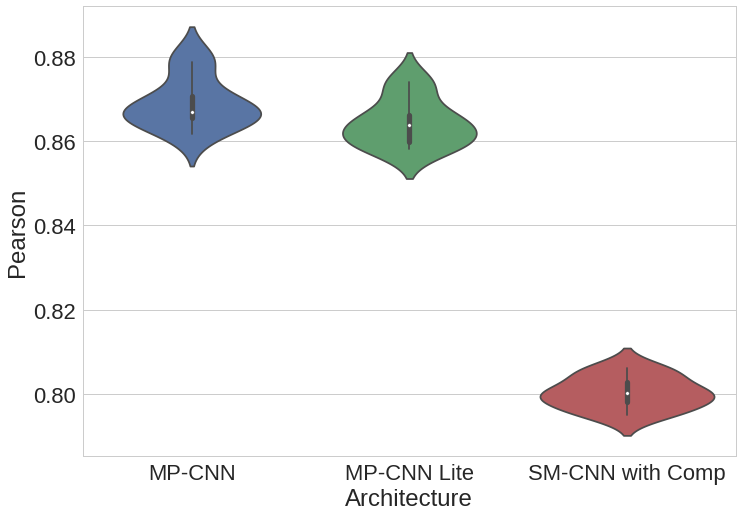

In [228]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.violinplot(x='arch', y='metric_val', data=sick_pearson_vs_archs_test, order=archs, ax=ax)
plt.xlabel('Architecture', fontsize=24)
plt.ylabel('Pearson', fontsize=24)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
# plt.ylim(0.86, 0.88)

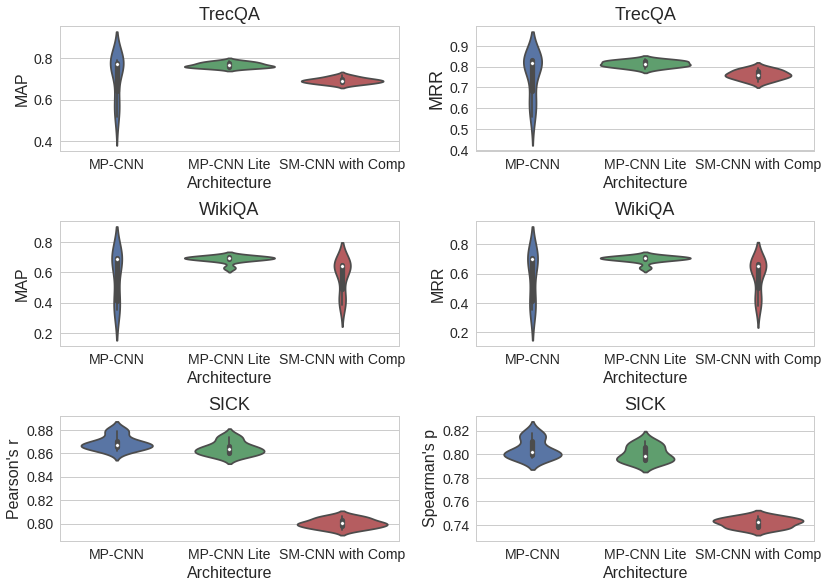

In [230]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
title_size = 18
axis_size = 16
tick_size = 14

ax = plt.subplot(321)
sns.violinplot(x='arch', y='metric_val', data=trec_map_vs_archs_test, order=archs, ax=ax)
plt.ylabel('MAP', fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title('TrecQA', fontsize=title_size)

ax = plt.subplot(322)
sns.violinplot(x='arch', y='metric_val', data=trec_mrr_vs_archs_test, order=archs, ax=ax)
plt.ylabel('MRR', fontsize=18)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title('TrecQA', fontsize=title_size)

ax = plt.subplot(323)
sns.violinplot(x='arch', y='metric_val', data=wikiqa_map_vs_archs_test, order=archs, ax=ax)
plt.ylabel('MAP', fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title('WikiQA', fontsize=title_size)

ax = plt.subplot(324)
sns.violinplot(x='arch', y='metric_val', data=wikiqa_mrr_vs_archs_test, order=archs, ax=ax)
plt.ylabel('MRR', fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title('WikiQA', fontsize=title_size)

ax = plt.subplot(325)
sns.violinplot(x='arch', y='metric_val', data=sick_pearson_vs_archs_test, order=archs, ax=ax)
plt.ylabel("Pearson's r", fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title('SICK', fontsize=title_size)

ax = plt.subplot(326)
sns.violinplot(x='arch', y='metric_val', data=sick_spearman_vs_archs_test, order=archs, ax=ax)
plt.ylabel("Spearman's p", fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title('SICK', fontsize=title_size)
plt.tight_layout()

plt.savefig('lite-model-violin.pdf')